# Hypothesis Testing

Python notebook for illustrating the concept of Hypothesis Testing and specific test statistics; among them the very useful Kolmogorov-Smirnov test.

The Kolmogorov-Smirnov test (KS test) is a general test to evaluate if two distributions in 1D are the same. This program applies three hypothesis tests to determine, if two distributions are the same:
1. A simple comparison of means.
2. A $\chi^2$-test between histograms.
3. An unbinned KS test

The distributions compared are two unit Gaussians (A and B), where one is then modified by changing:
- Mean
- Width
- Normalisation

The sensitivity of each test is then considered for each of these changes.

### References:
- Barlow: p. 155-156
- __[Wikipedia: Kolmogorov-Smirnov test](http://en.wikipedia.org/wiki/Kolmogorov-Smirnov_test)__
- Though influenced by biostatistics, a good discussion of p-values and their distribution can be found here:
  [How to interpret a p-value histogram?](http://varianceexplained.org/statistics/interpreting-pvalue-histogram/)

### Authors: 
Troels C. Petersen (Niels Bohr Institute)

### Date:    
07-12-2022 (latest update)

***

In [407]:
import numpy as np                                     # Matlab like syntax for linear algebra and functions
import matplotlib.pyplot as plt                        # Plots and figures like you know them from Matlab
import seaborn as sns                                  # Make the plots nicer to look at
from iminuit import Minuit                             # The actual fitting tool, better than scipy's
import sys                                             # Module to see files and folders in directories
from scipy.special import erfc
from scipy import stats

sys.path.append('../../External_Functions')
from ExternalFunctions import Chi2Regression, BinnedLH, UnbinnedLH
from ExternalFunctions import nice_string_output, add_text_to_ax # useful functions to print fit results on figure

Set the parameters of the plot:

In [408]:
r = np.random             # Random generator
r.seed(42)                # Set a random seed (but a fixed one)

save_plots = False
verbose = True

The small function below is just a simple helper function that takes a 1D-array input along with an axis, position and color arguments an plot the number of entries, the mean and the standard deviation on the axis:

In [409]:
def ax_text(x, ax, posx, posy, color='k'):
    d = {'Entries': len(x), 
         'Mean': x.mean(),
         'STD': x.std(ddof=1),
        }    
    add_text_to_ax(posx, posy, nice_string_output(d), ax, fontsize=12, color=color)
    return None

and finally a function that calculates the mean, standard deviation and the standard deviation (i.e. uncertainty) on mean (sdom):

In [410]:
def mean_std_sdom(x):
    std = np.std(x, ddof=1)
    return np.mean(x), std, std / np.sqrt(len(x))

## Set up the experiment:

How many experiments, and how many events in each:

In [411]:
N_exp = 5000
N_events_A = 1000
N_events_B = 1000

Define the two Gaussians to be generated (no difference to begin with!):

In [412]:
dist_mean_A  =  0.0
dist_width_A =  1.0
dist_mean_B  =  0.0
dist_width_B =  1.0

Define the number of bins and the range, initialize empty arrays to store the results in and make an empty figure (to be filled in later):

In [413]:
N_bins = 100
xmin, xmax = -5.0, 5.0

all_p_mean = np.zeros(N_exp)
all_p_chi2 = np.zeros(N_exp)
all_p_ks   = np.zeros(N_exp)

# Figure for the two distributions, A and B, in the first experiment:
fig1, ax1 = plt.subplots(figsize=(10, 6))
plt.close(fig1)


Loop over how many times we want to run the experiment, and for each calculate the p-value of the two distributions coming from the same underlying PDF (put in calculations yourself):

   0:  p_mean: 0.24393   p_chi2: 0.00998   p_ks: 0.26347
   1:  p_mean: 0.58506   p_chi2: 0.06961   p_ks: 0.46596
   2:  p_mean: 0.95477   p_chi2: 0.16402   p_ks: 0.28780
   3:  p_mean: 0.30533   p_chi2: 0.45601   p_ks: 0.57289
   4:  p_mean: 0.49208   p_chi2: 0.65348   p_ks: 0.91369
   5:  p_mean: 0.51781   p_chi2: 0.96432   p_ks: 0.93577
   6:  p_mean: 0.21666   p_chi2: 0.52245   p_ks: 0.37012
   7:  p_mean: 0.39776   p_chi2: 0.83770   p_ks: 0.79466
   8:  p_mean: 0.95712   p_chi2: 0.96600   p_ks: 0.95422
   9:  p_mean: 0.42311   p_chi2: 0.82525   p_ks: 0.19957
Got to experiment number: 1000
Got to experiment number: 2000
Got to experiment number: 3000
Got to experiment number: 4000
Got to experiment number: 5000


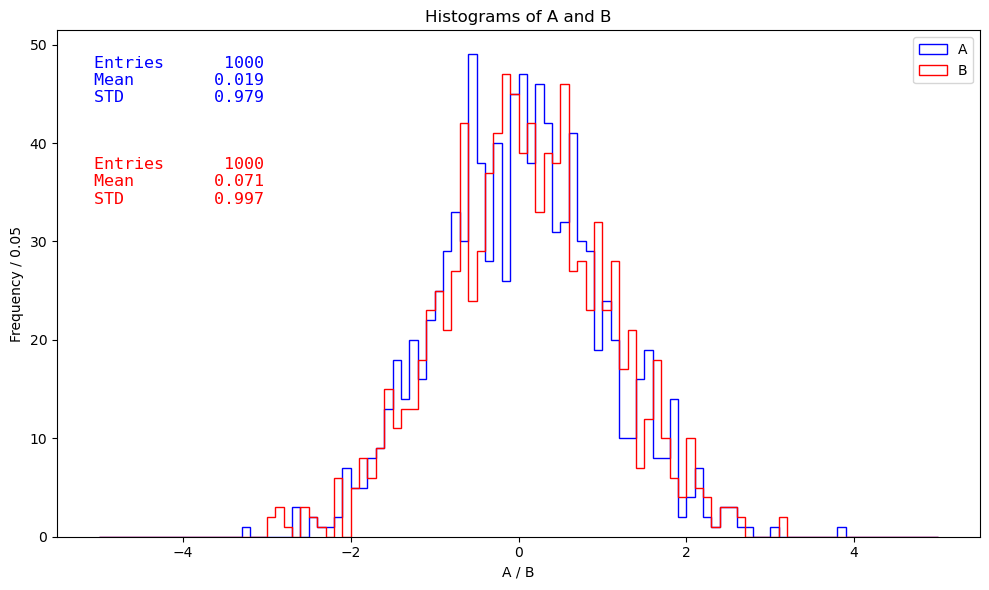

In [414]:
for iexp in range(N_exp):
    if ((iexp+1)%1000 == 0):
        print(f"Got to experiment number: {iexp+1}")

    # Generate data:
    x_A_array = r.normal(dist_mean_A, dist_width_A, N_events_A)
    x_B_array = r.normal(dist_mean_B, dist_width_B, N_events_B)
    
    
    # Test if there is a difference in the mean:
    # ------------------------------------------
    # Calculate mean, standard deviation, and error on mean (sdom):
    mean_A, std_A, sdom_A = mean_std_sdom(x_A_array)
    mean_B, std_B, sdom_B = mean_std_sdom(x_B_array)

    # Consider the difference between means in terms of the uncertainty:
    d_mean = mean_A - mean_B
    d_sdom = np.sqrt(sdom_A**2 + sdom_B**2)
    # ... how many sigmas is that away?

    # Turn a number of sigmas into a probability (i.e. p-value):
    p_mean    = 2*stats.norm.sf(np.abs(d_mean/d_sdom))      # Calculate yourself. HINT: "stats.norm.cdf or stats.norm.sf may be useful!"
    all_p_mean[iexp] = p_mean
    
    
    # Test if there is a difference with the chi2:
    # --------------------------------------------
    # Chi2 Test:
    x_A_Counts, x_A_Bins = np.histogram(x_A_array, N_bins, (xmin, xmax))
    x_B_Counts, x_B_Bins = np.histogram(x_B_array, N_bins, (xmin, xmax))
    mask = (x_A_Counts + x_B_Counts) > 0
    x_A_Counts = x_A_Counts[mask]
    x_B_Counts = x_B_Counts[mask]
    chi2 = np.sum((x_A_Counts - x_B_Counts)**2 / (x_A_Counts + x_B_Counts))
    p_chi2 = stats.chi2.sf(chi2, np.sum(mask))         # Calculate the p-value of the Chi2 between histograms of A and B yourself.
    all_p_chi2[iexp] = p_chi2

    
    # Test if there is a difference with the Kolmogorov-Smirnov test on arrays (i.e. unbinned):
    # -----------------------------------------------------------------------------------------
    p_ks = stats.ks_2samp(x_A_array, x_B_array)[1]    # Fortunately, the K-S test is implemented in stats!
    all_p_ks[iexp] = p_ks


    # Print the results for the first 10 experiments
    if (verbose and iexp < 10) :
      print(f"{iexp:4d}:  p_mean: {p_mean:7.5f}   p_chi2: {p_chi2:7.5f}   p_ks: {p_ks:7.5f}")

    
    # In case one wants to plot the distribution for visual inspection:
    if (iexp == 0):
        
        ax1.hist(x_A_array, N_bins, (xmin, xmax), histtype='step', label='A', color='blue')
        ax1.set(title='Histograms of A and B', xlabel='A / B', ylabel='Frequency / 0.05')        
        ax_text(x_A_array, ax1, 0.04, 0.95, 'blue')

        ax1.hist(x_B_array, N_bins, (xmin, xmax), histtype='step', label='B', color='red')
        ax_text(x_B_array, ax1, 0.04, 0.75, 'red')
        
        ax1.legend()
        fig1.tight_layout()

        
fig1

## Show the distribution of hypothesis test p-values:

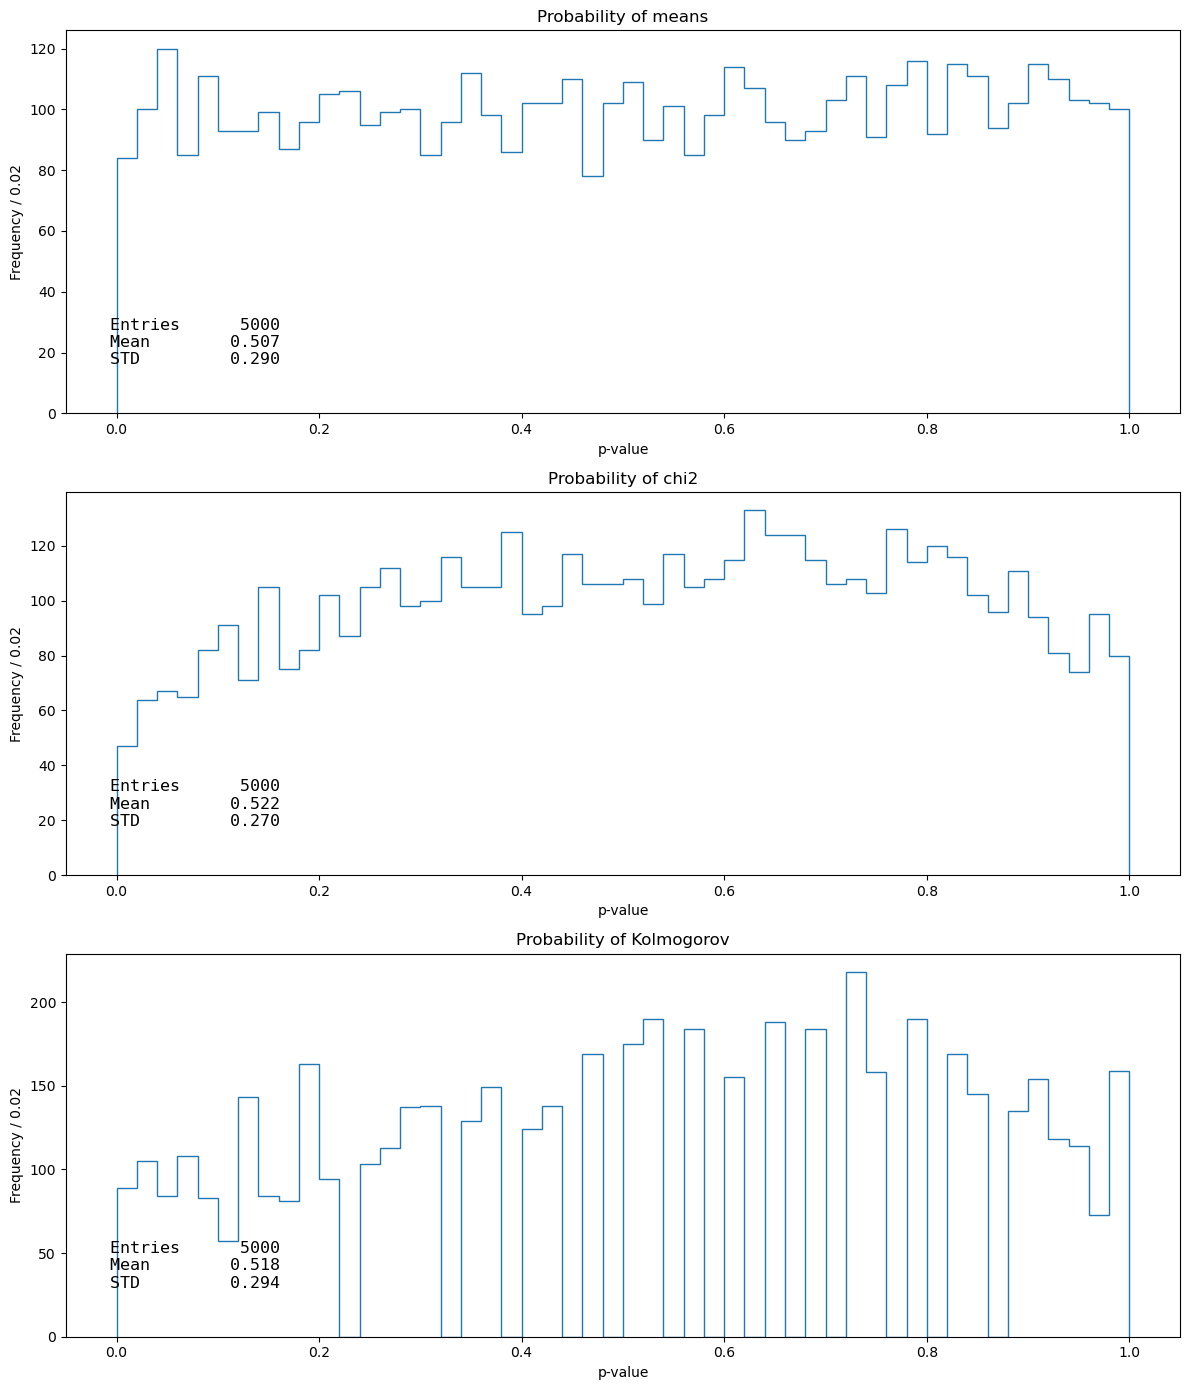

In [415]:
N_bins = 50

if (N_exp > 1):
    fig2, ax2 = plt.subplots(nrows=3, figsize=(12, 14))
    
    ax2[0].hist(all_p_mean, N_bins, (0, 1), histtype='step')
    ax2[0].set(title='Probability of means', xlabel='p-value', ylabel='Frequency / 0.02')
    ax_text(all_p_mean, ax2[0], 0.04, 0.25)
    

    ax2[1].hist(all_p_chi2, N_bins, (0, 1), histtype='step')
    ax2[1].set(title='Probability of chi2', xlabel='p-value', ylabel='Frequency / 0.02')
    ax_text(all_p_chi2, ax2[1], 0.04, 0.25)
    
    ax2[2].hist(all_p_ks, N_bins, (0, 1), histtype='step')
    ax2[2].set(title='Probability of Kolmogorov', xlabel='p-value', ylabel='Frequency / 0.02')
    ax_text(all_p_ks, ax2[2], 0.04, 0.25)

    fig2.tight_layout()


    if save_plots:
        fig2.savefig('PvalueDists.pdf', dpi=600)

# Questions:

1. First run the program with one experiment (N_exp = 1) to display the two distributions A and B, when:
    - They are the same.
        Fine results. Probability on mean gives a chance of 34% to get a larger difference. The probability of the chi2 is 51% for Nbins = 50, but is very sensitive to the number of bins. 
        The KS test gives a probability of 70%, which is in agreement with the mean test. 
    - The mean of A is increased (to e.g. 0.1).
        Especially the mean is sensitive to this change and changes to 84%. The chi2 probability also falls to 18% with the KS test stil at about 70%.
    - The width of A is enlarged (to e.g. 1.2).
        The mean probability has a hard time seeing the problem and estimates 31% outside. The chi2 probability is 23%  and KS is 58%. 
    - The normalisation of A is increased.
        Again the mean test is not sensitive to this change and gives a probability of 40%. The chi2 probability is 0% and KS is 20%.

Get a feel for how much you need to change the distribution, before you can _by eye_ see that they are not the same. I.e. can you see any difference, if `mean_A` $= 0.1$? Or how about $0.2$? How do you quantify this and when do you start to doubt? 


And how about `width_A` $= 1.1$? Or $1.2$? Again, can you see it by eye? 

Finally, try to put $1050$ events into B. Is that visible? How about $1100$?<br>
When you have an idea about when you can see effects by eye, now check if you see an impact in the p-values?

2. Could you for the test of the means have calculated how much of a change in the mean is needed for a difference to be statistically significant? Do so, and see if it somewhat matches you guess/estimate from above!


3. Now run the tests 1000 times, where A and B are unit Gaussians and thus identical. How should the distributions of the test probabilities come out? And is this the case, approximately? If not, think of reasons for this, and what could be a remedy. HINT: Large statistics is always easier!

The probability distributions should come out uniform.

4. Repeat the changes in question 1), and see which tests "reacts" most to these modifications. How much of a change in the mean is required for 95% of the tests (of each kind) to give a probability below 5%? How much is required for the width? And the norm?

Change in mean is of course seen most in test of mean, while that test cannot see the other changes. the other 2 tests are more sensitive to the other changes.

5. Possibly try to test different distributions than the Gaussian one (e.g. exponential, uniform, etc.), and see how the tests performs.



NOTE: The Kolmogorov-Smirnov test has the great advantage that it can handle ANY distribution (even the Cauchy distribution - remind yourself of that one!). The reason is, that it doesn't care about any PDF, nor how far out an outlier is. It is just a matter of the difference in integrals between the two functions.


## Advanced:

6. Obviously, the test of the means is not sensitive the a change in the width. Make such a test yourself by calculating the widths and the uncertainty on the widths (or perhaps try the F-test!). Note that in a (unit) Gaussian the uncertainty on the width is of the same order as that of the means!


## Very advanced:
7. Implement in python the following tests:
     - Lilliefors test
     - Shapiro-Wilk test
     - Anderson-Darling test
     - Cramer-von-Mises test
     - Jarque-Bera test
     - Kuiper's test
     - Mann-Whitney-Wilcoxon test
     - Siegel-Tukey test
     
and quantify under various conditions and datasets the power of each and the correlation among them. Write it up, and send it to a statistics journal. :-)

# Learning points:

The exercise should give you a good idea about the process of hypothesis testing, namely that you calculate a p-value, which under the null hypothesis is uniformly distributed.

You should be aware that in this exercise, we "play Gods" and repeat a perfect experiment over and over, to see the changes in the p-value distribution, when we change one of the input distributions. However, when you have real data, you will only get a single p-value! And you should be in a position, where you trust (and have perhaps tested using simulation) that the p-value really is uniform for the null hypothesis, and thus points to something "non-null", if very low.

The three tests (means, chi2, and KS) are some of the very standard approaches, but there are certainly also others.